# **1. Objectif**


L'objectif est de faire des prédictions à long terme de la température quotidienne à Sydney en utilisant l'analyse de **séries temporelles**.

Je commencerai cependant par un modèle **naif** afin d'étudier la pertinence de l'utilisation de modèle de série temporelle pour cette situation.

Les températures connues sont quotidiennes sur la période de 2014 à 2016.

La prédiction est sur l'année 2017.

Nous connaissons aussi les températures réelles sur la première partie de l'année 2017 afin d'étudier la performance de nos modèles.

# **2. Importation des bibliothèques**


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

# **3. Jeu de données**

**Lecture du dataset :**

In [2]:

path_file_1 = "data/weatherAus.csv"

df = pd.read_csv(path_file_1,  header=0, parse_dates=[0], index_col=0)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Vérification que la variable 'date' est bien en index et de type Datetime :**

In [3]:
df.index


DatetimeIndex(['2008-12-01', '2008-12-02', '2008-12-03', '2008-12-04',
               '2008-12-05', '2008-12-06', '2008-12-07', '2008-12-08',
               '2008-12-09', '2008-12-10',
               ...
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', length=145460, freq=None)

**Création de data : 'Temp9am' à Sydney de 2014 à 2016 :**

On s'interesse aux température observées à Sydney de 2014 à 2016 afin de prévoir les températures en 2017.
Supression des 29 février afin que les 3 années aient le même nombre de jours par simplicité (et 2017 ne présente pas de 29 février).

In [4]:
df_Sydney = df[df['Location']=='Sydney']
df_Sydney = df_Sydney[(df_Sydney.index.year==2014)|(df_Sydney.index.year== 2015)|(df_Sydney.index.year==2016)]
df_Sydney = df_Sydney[df_Sydney.index!='2016-02-29']
data = df_Sydney [['Temp9am']]

print('data shape :',data.shape)
data.head()


data shape : (1095, 1)


,Temp9am
Date,
2014-01-01,24.4
2014-01-02,27.1
2014-01-03,22.2
2014-01-04,22.9
2014-01-05,24.2


**Gestion des NAN :**

In [5]:
print('Il y a {} Nan dans data.'.format(data.isna().sum().sum()))


Il y a 1 Nan dans data.


In [6]:
# remplacement de la valeur manquante par la valeur de la veille

data = data.iloc[:].fillna(method='ffill',limit=1)
print('Il y a {} Nan dans data.'.format(data.isna().sum().sum()))


Il y a 0 Nan dans data.


**data, dataframe retenu pour les modélisations :**

In [7]:
print('Dimension du dataframe data :',data.shape)

data.head()


Dimension du dataframe data : (1095, 1)


,Temp9am
Date,
2014-01-01,24.4
2014-01-02,27.1
2014-01-03,22.2
2014-01-04,22.9
2014-01-05,24.2


# **4. Visualisations**

**Observations des températures quotidiennes :**

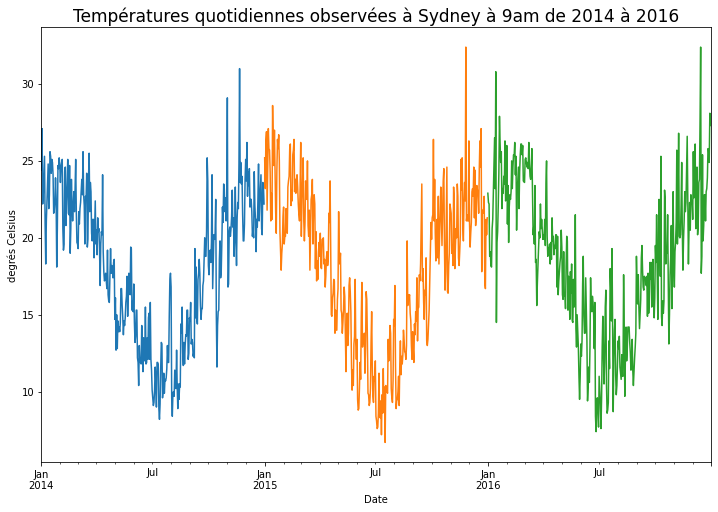

In [8]:
plt.figure(figsize = (12, 8))

data.resample('Y').plot()
plt.title('Températures quotidiennes observées à Sydney à 9am de 2014 à 2016', size=17)
plt.ylabel('degrés Celsius');


**Lissage des températures avec rééchantillonnage des données sur une base mensuelle et hebdomadaire (température moyenne) :**

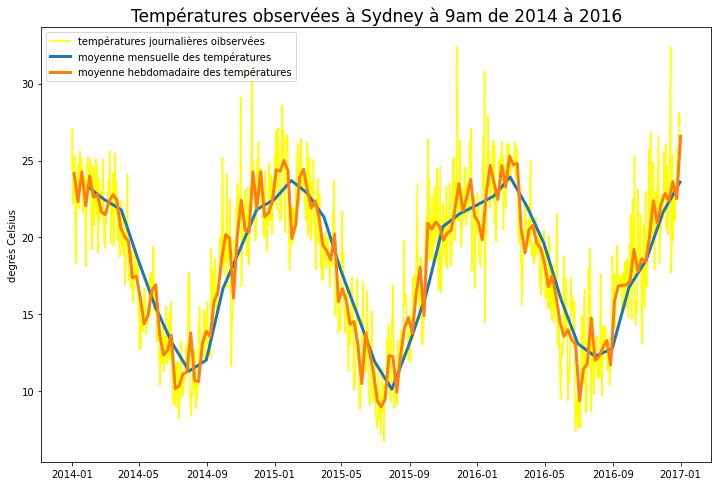

In [9]:
plt.figure(figsize = (12,8))

plt.plot(data, color='yellow', label = 'températures journalières oibservées')
plt.plot(data.resample('M').mean(), label = 'moyenne mensuelle des températures ', lw=3, ls='-')
plt.plot(data.resample('W').mean(), label = 'moyenne hebdomadaire des températures', lw=3, ls='-')
plt.title("Températures observées à Sydney à 9am de 2014 à 2016", size=17)
plt.ylabel('degrés Celsius')
plt.legend();


# **5. Un premier modèle naïf**

**Création d'un dataframe naïf représentant la température moyenne journalière des 3 années 2014 à 2016.
Ce sera mon modèle naïf de prédiction pour 2017.**

In [10]:
naif = data.groupby([data.index.month, data.index.day]).mean()
naif.head()


Temp9am
Date Date           
1    1     24.166667
     2     24.200000
     3     23.566667
     4     22.866667
     5     21.700000

**Création d'un dataframe contenant les températures observées en 2017 : data_2017**

In [11]:
df_Sydney = df[df['Location']=='Sydney']
df_Sydney = df_Sydney[(df_Sydney.index.year== 2017)]
data_2017 = df_Sydney [['Temp9am']]

print('data_2017 shape :',data_2017.shape)
data_2017.head()


data_2017 shape : (176, 1)


,Temp9am
Date,
2017-01-01,24.6
2017-01-02,22.1
2017-01-03,21.9
2017-01-04,24.0
2017-01-05,20.5


**Visualisation des températures observées et des températures prédites avec le modèle naïf en 2017**

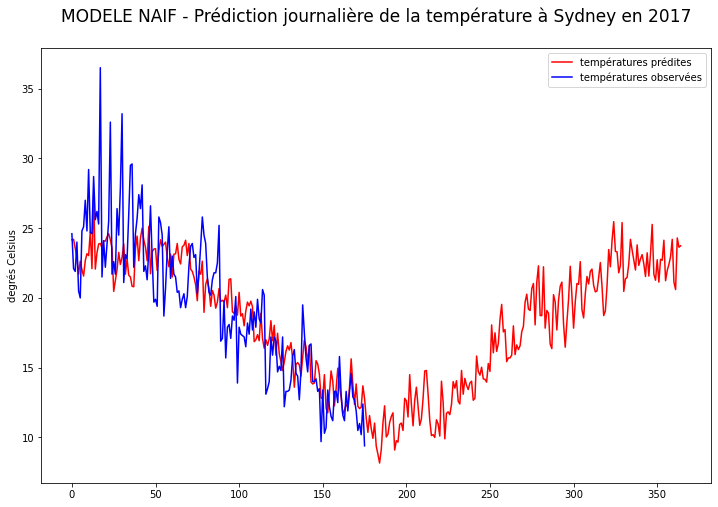

In [12]:
plt.figure(figsize=(12,8))

plt.plot(naif.values, color = 'red', label='températures prédites')
plt.plot(data_2017.values, color='blue', label='températures observées')
plt.title('MODELE NAIF - Prédiction journalière de la température à Sydney en 2017\n', size=17)
plt.ylabel('degrés Celsius')
plt.legend();


# **6. Etude de la série temporelle**

## **6.1 Décompostion manuelle de la série temporelle.**

**Identification de la tendance : moyenne mobile centrée sur un an :**

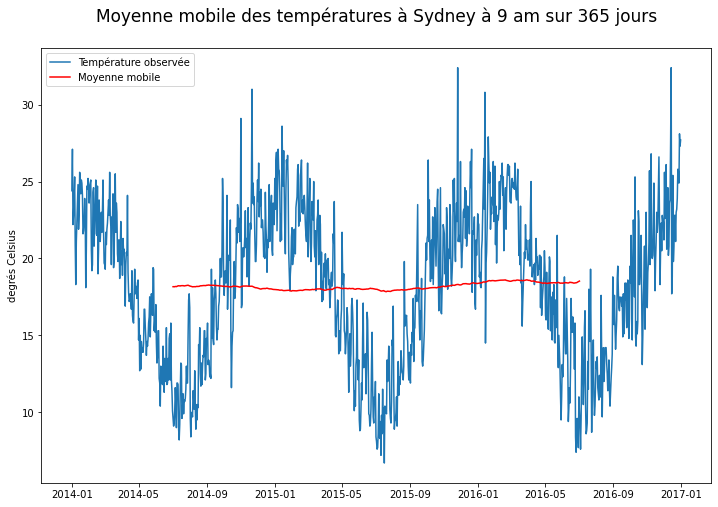

In [13]:
# On a une saisonnalité de période 365

data_ma = data.rolling(window = 365, center = True).mean()

# Affichage

plt.figure(figsize=(12,8))

plt.plot(data, label = 'Température observée')
plt.plot(data_ma, color = 'red', label = 'Moyenne mobile')
plt.title('Moyenne mobile des températures à Sydney à 9 am sur 365 jours\n', size=17)
plt.ylabel('degrés Celsius')
plt.legend();


**La moyenne mobile permet d'identifier la tendance. La tendance est visuellement très faible ici.**

**Identification des coefficients de saisonnalité :**

In [14]:
# data_without_ma est la différence entre la série et sa moyenne mobile avec suppression des valeurs manquantes

data_without_ma = data - data_ma
data_without_ma.dropna(inplace=True)

# Ajout d'une colonne 'day' et Ajout d'une colonne 'month'

data_without_ma['day'] = data_without_ma.index.day
data_without_ma['month'] = data_without_ma.index.month

data_without_ma.head()


,Temp9am,day,month
Date,,,
2014-07-02,-8.563562,2,7
2014-07-03,-9.065753,3,7
2014-07-04,-8.855068,4,7
2014-07-05,-8.066301,5,7
2014-07-06,-6.577260,6,7


In [15]:
# Moyenne par jour à l'aide de groupy

seasonality=data_without_ma.groupby(['month','day']).mean()

# Centrage des coefficients

seasonality = seasonality - seasonality.mean()

print('seasonality.shape:' , seasonality.shape)

seasonality.head()


seasonality.shape: (365, 1)


Temp9am
month day          
1     1    5.876535
      2    4.576398
      3    6.078727
      4    4.679412
      5    2.277631

**Seasonality contient les 365 coefficients saisonniers.**

In [16]:
# Vérifications du nombre de jours dans data par année 

for i in range(2014,2017) :
  print(i, ' a :', (data.index.year==i).sum(), 'jours')


2014  a : 365 jours
2015  a : 365 jours
2016  a : 365 jours


**Série corrigée des valeurs saisonnières :**

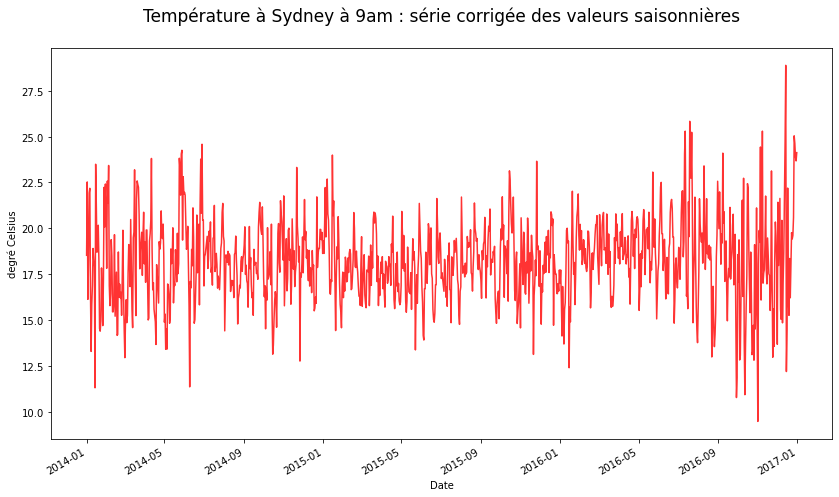

In [17]:
# Vecteur avec coefficients saisonniers :
 
seasonal_vector=np.zeros(3*365)
seasonal_vector[:365] = seasonality.iloc[:,0]
seasonal_vector[365:2*365] = seasonality.iloc[:,0]
seasonal_vector[2*365:3*365] = seasonality.iloc[:,0]

# Série originale corrigée de ses valeurs saisonnières

data_csv=data.iloc[:,0] - seasonal_vector

plt.figure(figsize=(14,8))

data_csv.plot(color='red', alpha=0.8)
plt.ylabel('degré Celsius')
plt.title('Température à Sydney à 9am : série corrigée des valeurs saisonnières\n', size=17);


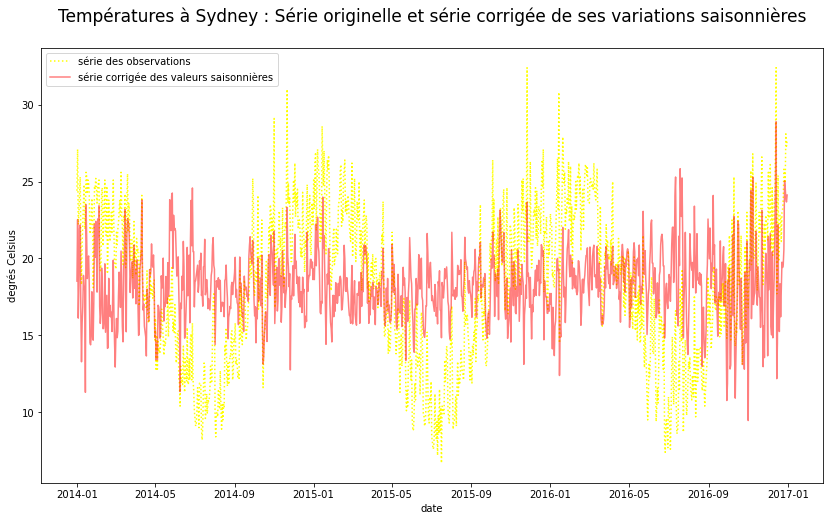

In [18]:
plt.figure(figsize=(14,8))

plt.plot(data, ':', color='yellow', label = 'série des observations')
plt.plot(data_csv, color='red', alpha=0.5, label = 'série corrigée des valeurs saisonnières')
plt.title('Températures à Sydney : Série originelle et série corrigée de ses variations saisonnières\n', size=17)
plt.xlabel('date')
plt.ylabel('degrés Celsius')
plt.legend();


## **6.2 Décomposition automatique de la série temporelle**

**Visualisation de la série,  de la tendance, de la saisonnalité et du résidu :**

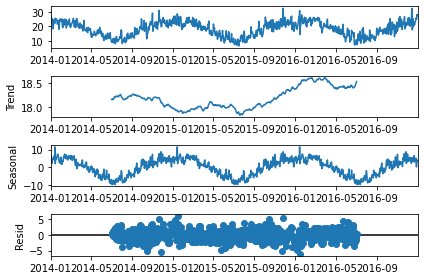

In [19]:
res = seasonal_decompose(data,  model='additive', period=365)

res.plot()
plt.show();


**Visualisation de la série corrigée de ses valeurs saisonnières :**

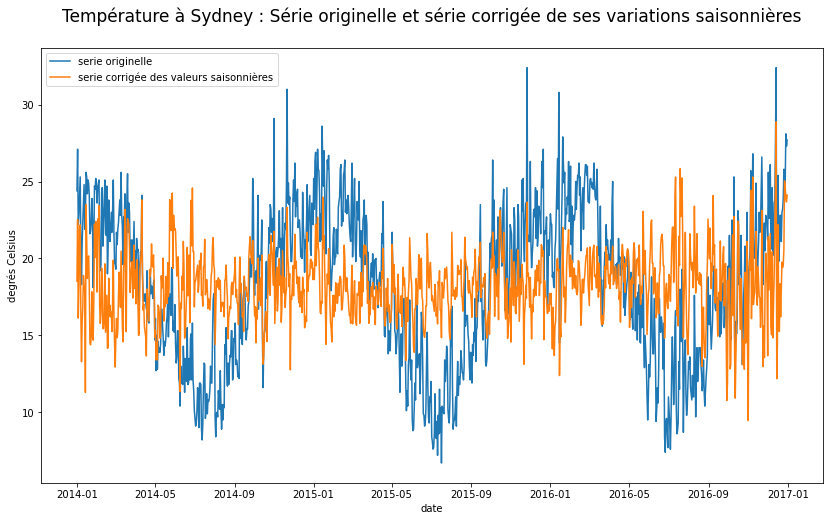

In [20]:
cvs = data['Temp9am'] - res.seasonal

plt.figure(figsize=(14,8))

plt.plot(data, label='serie originelle')
plt.plot(cvs, label='serie corrigée des valeurs saisonnières')
plt.ylabel('degrés Celsius')
plt.xlabel('date')
plt.legend()
plt.title('Température à Sydney : Série originelle et série corrigée de ses variations saisonnières\n', size=17);


## **6.3 Série et Fonction d'autocorélation de la série**


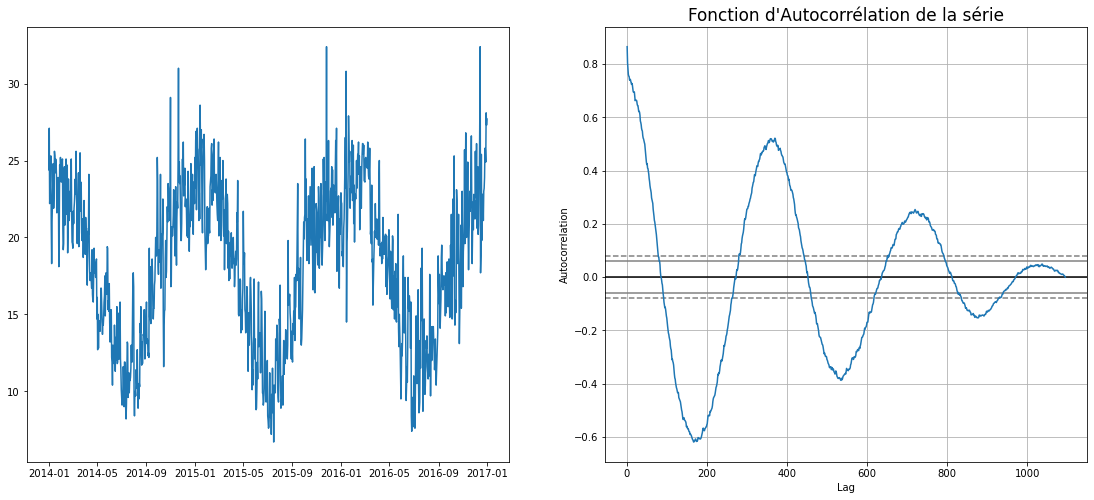

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(19,8))

ax1.plot(data)
pd.plotting.autocorrelation_plot(data, ax = ax2)
plt.title("Fonction d'Autocorrélation de la série", size=17);


 **On constate que la décroissance de la fonction d'autocorrélation est relativement lente. On applique donc une différenciation d'ordre 1 sur notre série temporelle afin de voir si cela nous permet de la stationnariser :**

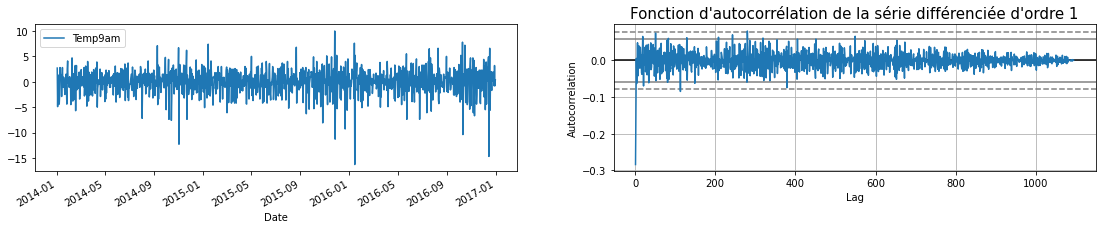

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(19,3))

data_1 = data.diff().dropna()
data_1.plot(ax=ax1)
pd.plotting.autocorrelation_plot(data_1, ax=ax2)
plt.title("Fonction d'autocorrélation de la série différenciée d'ordre 1", size=15);


**L'autocorrélation simple semble tendre vers 0 mais nous allons différencier la série temporelle de manière à éliminer la saisonnalité. L'utilisation du pramètre periods de la méthode diff permet de différencier une série temporelle afin de la désaisonnaliser selon une période, ici 365 :**

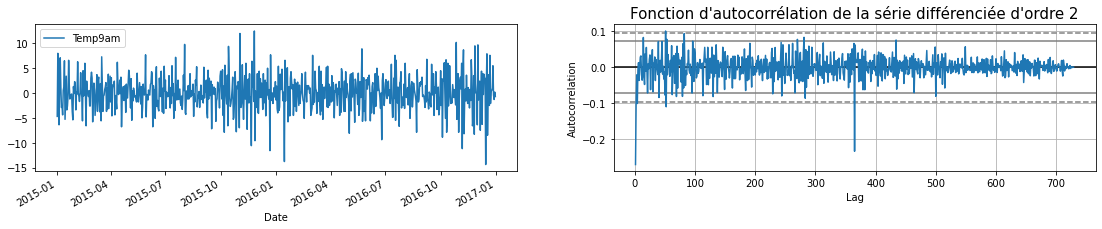

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(19,3))

data_2 = data_1.diff(periods=365).dropna()
data_2.plot(ax=ax1)
pd.plotting.autocorrelation_plot(data_2, ax=ax2)
plt.title("Fonction d'autocorrélation de la série différenciée d'ordre 2", size=15);


**Test statistique pour vérifier que la série obtenue par double différenciation est stationnaire :**

In [24]:
sm.tsa.stattools.adfuller(data_2.iloc[:,0])[1]


9.276901103894771e-20

**Le test statistique réalisé (le test augmenté de Dickey-Fuller (ADF)) a une p-valeur quasi nulle. On peut donc considérer la série comme stationnaire.**

# **7. Modélisation SARIMA**

Le processus SARIMA  combine à la fois une différenciation simple et saisonnière. Un modèle SARIMA s'écrit sous la forme SARIMA⁡(p,d,q)(P,D,Q)k

J'ai identifié une saisonnalité de période 365 ( k=365). De plus j'ai fait une différenciation simple (d=1) et une différenciation saisonnière (D=1) pour stationnariser la série temporelle.

Ainsi le modèle sera de la forme SARIMA⁡(p,1,q)(P,1,Q)365 . Il convient alors de choisir les bons ordres p, q, P et Q.

Ordres des modèles AR(p) ou MA(q) :

Pour déterminer les ordres d'un processus  AR  ou  MA , il est possible de s'appuyer à nouveau sur ses diagrammes d'autocorrélation ou autocorrélogrammes.

**Affichage des diagrammes d'autocorrélation simple et partiel :**

C:\Users\33661\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


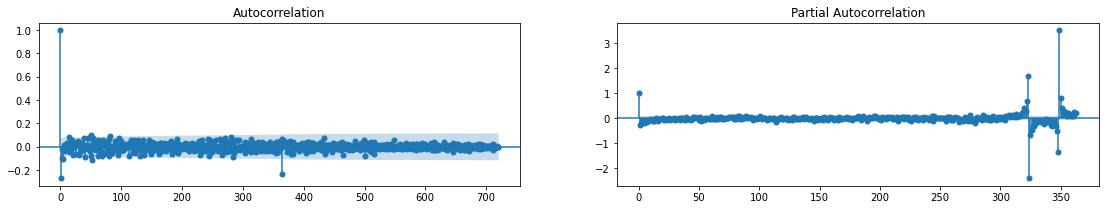

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,(ax1,ax2)=plt.subplots(1,2, figsize=(19,3))
plot_acf(data_2, lags=720, ax=ax1)
plot_pacf(data_2, lags=363, ax=ax2);

plt.show();


On remarque qu'à la fois l'autocorrélation simple et partielle tendent vers 0 (hormis les pics saisonniers), il ne semble pas y avoir de coupure en particulier. On peut donc supposer un processus  ARMA(p,q) . Je vais donc commencer par estimer via un  ARMA(1,1)  la partie non saisonnière de notre série temporelle.

Pour les ordres saisonniers (P et Q), il faudrait de se référer aux mêmes règles mais en regardant uniquement les pics saisonniers mais difficile à lire ici(lag max 700 et 363).

Je vais donc débuter en entrainant un modèle SARIMA(1,1,1)(0,1,0)365.


**Entrainement du modèle :**

In [26]:
m = sm.tsa.SARIMAX(data, order=(1,1,1), seasonal_order = (0,1,0,365))

m_fitted = m.fit()
m_fitted

print(m_fitted.summary())


C:\Users\33661\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\33661\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                      SARIMAX Results                                       
Dep. Variable:                              Temp9am   No. Observations:                 1095
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 365)   Log Likelihood               -1848.171
Date:                              Wed, 31 Aug 2022   AIC                           3702.343
Time:                                      16:37:48   BIC                           3716.118
Sample:                                           0   HQIC                          3707.657
                                             - 1095                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4940      0.033     15.113      0.000       0.430       0.558
ma.L1         -0.99

Analyse des résultats avec la méthode summary() du modèle ajusté : 

La colonne qui nous intéresse le plus est la  4ème (P>|z|) qui indique la p-valeur pour la significativité de chaque paramètre.


Les p-valeur des paramètres sont nulles donc ils semblent être significatifs dans le modèle. 

Le test de Ljung-Box est un test de blancheur des résidus. C'est un test statistique qui vise à rejeter ou non l'hypothèse  H0  : Le résidu est un bruit blanc. Ici on lit sur la ligne Prob(Q) que la p-valeur de ce test est de  0.78 donc on ne rejette pas l'hypothèse.

Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse  H0  : Le résidu suit une distribution normale. Ici on lit sur la ligne Prob (JB) que la p-valeur du test est de 0. On ne rejette donc pas l'hypothèse.

Le résidu vérifie les hypothèses que l'on a faites à priori. On peut donc conclure que le modèle  SARIMA(0,1,1)(0,1,0) est satisfaisant.



**Prédiction de la température l'année suivante (2017) :**

In [27]:
pred = m_fitted.predict(1095,1459)
print(pred)


C:\Users\33661\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


1095    26.260876
1096    24.159461
1097    23.317719
1098    19.551278
1099    19.670245
          ...    
1455    26.093485
1456    25.293485
1457    28.493485
1458    27.693485
1459    28.093485
Name: predicted_mean, Length: 365, dtype: float64


**Concaténation des prédictions à la série originale :**

In [28]:
datapred = pd.concat([data,pred]).reset_index(drop=True)
datapred.columns = ['Temp9am observées', 'Temp9am prédites']
datapred


,Temp9am observées,Temp9am prédites
0,24.4,NaN
1,27.1,NaN
2,22.2,NaN
3,22.9,NaN
4,24.2,NaN
...,...,...
1455,NaN,26.093485
1456,NaN,25.293485
1457,NaN,28.493485
1458,NaN,27.693485


**Visualisation de l'intégralité de la série ainsi que les prédictions effectuées :**

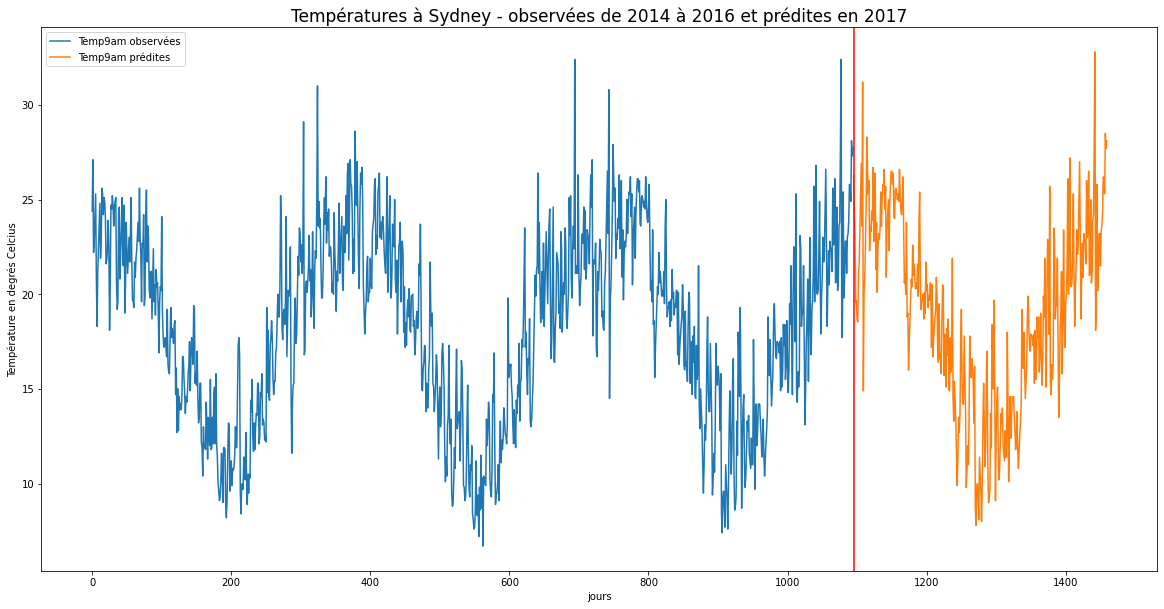

In [29]:
datapred.plot(figsize=(20,10))
plt.axvline(x=1095, color='red')
plt.title('Températures à Sydney - observées de 2014 à 2016 et prédites en 2017', size=17)
plt.ylabel('Température en degrés Celcius')
plt.xlabel('jours');


**Ajout des températures observées en 2017 à la colonne 'Temp9am observées' de datapred :**


In [30]:
datapred['Temp9am observées'][1095:1095+176]=data_2017['Temp9am'][:]
datapred


,Temp9am observées,Temp9am prédites
0,24.4,NaN
1,27.1,NaN
2,22.2,NaN
3,22.9,NaN
4,24.2,NaN
...,...,...
1455,NaN,26.093485
1456,NaN,25.293485
1457,NaN,28.493485
1458,NaN,27.693485


In [31]:
datapred['Temp9am observées'][1095:1095+176]


1095    24.6
1096    22.1
1097    21.9
1098    24.0
1099    20.5
        ... 
1266    10.5
1267    11.0
1268    10.2
1269    12.4
1270     9.4
Name: Temp9am observées, Length: 176, dtype: float64

**Visualisation de l'intégralité de la série avec aussi les températures observées jusque 2017 ainsi que les prédictions effectuées en 2017 :**

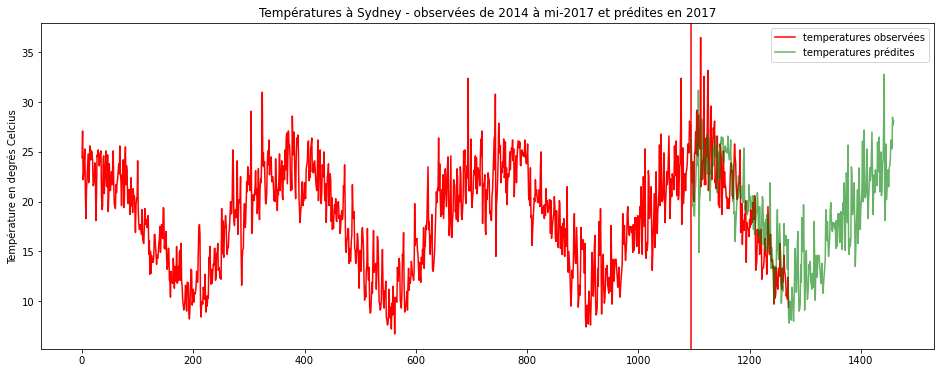

In [32]:
plt.figure(figsize=(16,6))

plt.plot(datapred['Temp9am observées'][:1095+176], color='red', label='temperatures observées')
plt.axvline(x=1095, color='red')
plt.plot(datapred['Temp9am prédites'][1095:], color='green',alpha=0.6,  label='temperatures prédites')
plt.title('Températures à Sydney - observées de 2014 à mi-2017 et prédites en 2017')
plt.ylabel('Température en degrés Celcius')
plt.legend();


# **8. Comparaison du modèle naif et du modèle SARIMA - MSE**

Je vais utiliser les températures observées en 2017 pour calculer l'erreur quadratique moyenne (MSE) avec d'une part le modèle naif et d'autre part le modèle Sarima afin d'étudier la pertinence dans cette situation du modèle Sarima

Je ne dispose que des températures quotidiennes observées en 2017 que sur la première partie de l'année.

**Série des températures observées en 2017 :**

In [33]:
y_true = data_2017['Temp9am'].values

print("Les températures observées en 2017 ne concernent que les {} premiers jours de l'année. Les autres sont indisponibles".format(y_true.shape[0]))


Les températures observées en 2017 ne concernent que les 176 premiers jours de l'année. Les autres sont indisponibles


**Série des températures prédites avec le modèle naif pour les 176 premiers jours de l'année 2017 :**

In [34]:
y_predict_naif = naif['Temp9am'].values[:176]
y_predict_naif.shape


(176,)

**Série des températures prédites avec le modèle Sarima pour les 176 premiers jours de l'année 2017 :**

In [35]:
y_predict_sarima = pred.values[:176]
y_predict_sarima.shape


(176,)

**Calcul de la MSE (ereur quadratique moyenne) avec les deux modèles :**

In [36]:
mse_naif = mean_squared_error(y_true, y_predict_naif)
mse_sarima = mean_squared_error(y_true, y_predict_sarima)

print("L'erreur quadratique moyenne du modèle naif est :", round(mse_naif,2))
print("L'erreur quadratique moyenne du modèle sarima est :", round(mse_sarima,2))


L'erreur quadratique moyenne du modèle naif est : 8.32
L'erreur quadratique moyenne du modèle sarima est : 15.48


# **9. Conclusion**

**Le modèle naif est ici bien plus performant que le modèle Sarima. Ce dernier n'est donc pas pertinent pour prévoir la température à long terme et il vaut mieux se limiter au modèle naif de prédiction.**